<a href="https://colab.research.google.com/github/KseniyaSilenkova/-Final_examination_Switzerland/blob/main/read_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

In [23]:
# 
import pandas as pd
import numpy as np
%matplotlib inline

# импорт SARIMAX 
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # для определения (p,q) 
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей

# метрики
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

from io import StringIO

In [13]:
!wget https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv

--2021-12-21 20:09:15--  https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41654646 (40M) [text/plain]
Saving to: ‘owid-covid-data.csv.3’

owid-covid-data.csv 100%[===================>]  39.72M   124MB/s    in 0.3s    

2021-12-21 20:09:16 (124 MB/s) - ‘owid-covid-data.csv.3’ saved [41654646/41654646]



In [16]:
df = pd.read_csv('owid-covid-data.csv.3', index_col='date', parse_dates = True)
df

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-24,AFG,Asia,Afghanistan,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-25,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-26,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-27,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-28,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-16,ZWE,Africa,Zimbabwe,182057.0,4367.0,3748.571,4759.0,14.0,5.143,12063.009,289.355,248.379,315.329,0.928,0.341,1.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12390.0,1622279.0,107.491,0.821,12471.0,0.826,0.3006,3.3,tests performed,7058474.0,4023289.0,3035185.0,NaN,45074.0,26738.0,46.77,26.66,20.11,NaN,1772.0,14047.0,0.093,63.89,15092171.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
2021-12-17,ZWE,Africa,Zimbabwe,189567.0,7510.0,4821.429,4779.0,20.0,8.000,12560.618,497.609,319.466,316.654,1.325,0.530,1.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9483.0,1631762.0,108.120,0.628,11700.0,0.775,0.4121,2.4,tests p

In [17]:
df.location.value_counts().index

Index(['Mexico', 'Peru', 'Argentina', 'Thailand', 'Taiwan', 'South Korea',
       'Upper middle income', 'High income', 'United States', 'Macao',
       ...
       'Sint Maarten (Dutch part)', 'Kiribati', 'Cook Islands', 'Turkmenistan',
       'Tuvalu', 'Nauru', 'Palau', 'Tokelau', 'Pitcairn', 'Niue'],
      dtype='object', length=238)

Сбор данных по Швейцарии

In [18]:
df2 = df[df.location=='Switzerland']

In [19]:
df2

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-25,CHE,Europe,Switzerland,1.0,1.0,NaN,NaN,NaN,NaN,0.115,0.115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,8715494.0,214.243,43.1,18.436,12.644,57410.166,NaN,99.739,5.59,22.6,28.9,NaN,4.53,83.78,0.955,NaN,NaN,NaN,NaN
2020-02-26,CHE,Europe,Switzerland,1.0,0.0,NaN,NaN,NaN,NaN,0.115,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,8715494.0,214.243,43.1,18.436,12.644,57410.166,NaN,99.739,5.59,22.6,28.9,NaN,4.53,83.78,0.955,NaN,NaN,NaN,NaN
2020-02-27,CHE,Europe,Switzerland,8.0,7.0,NaN,NaN,NaN,NaN,0.918,0.803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,8715494.0,214.243,43.1,18.436,12.644,57410.166,NaN,99.739,5.59,22.6,28.9,NaN,4.53,83.78,0.955,NaN,NaN,NaN,NaN
2020-02-28,CHE,Europe,Switzerland,8.0,0.0,NaN,NaN,NaN,NaN,0.918,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.44,8715494.0,214.243,43.1,18.436,12.644,57410.166,NaN,99.739,5.59,22.6,28.9,NaN,4.53,83.78,0.955,NaN,NaN,NaN,NaN
2020-02-29,CHE,Europe,Switzerland,18.0,10.0,NaN,NaN,NaN,NaN,2.065,1.147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.44,8715494.0,214.243,43.1,18.436,12.644,57410.166,NaN,99.739,5.59,22.6,28.9,NaN,4.53,83.78,0.955,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-16,CHE,Europe,Switzerland,1165778.0,11077.0,9141.286,11879.0,25.0,23.286,133759.257,1270.955,1048.855,1362.975,2.868,2.672,1.14,294.0,33.733,1627.0,186.679,NaN,NaN,NaN,NaN,56728.0,13462260.0,1544.635,6.509,57713.0,6.622,0.171,5.8,tests performed,12979664.0,5930024.0,5780966.0,1416479.0,85680.0,67876.0,148.93,68.04,66.33,16.25,7788.0,4249.0,0.049,46.30,8715494.0,214.243,43.1,18.436,12.644,57410.166,NaN,99.739,5.59,22.6,28.9,NaN,4.53,83.78,0.955,NaN,NaN,NaN,NaN
2021-12-17,CHE,Europe,Switzerland,1175721.0,9943.0,9114.000,11910.0,31.0,23.429,134900.099,1140.842,1045.724,1366.532,3.557,2.688,1.15,299.0,34.307,1585.0,181.860

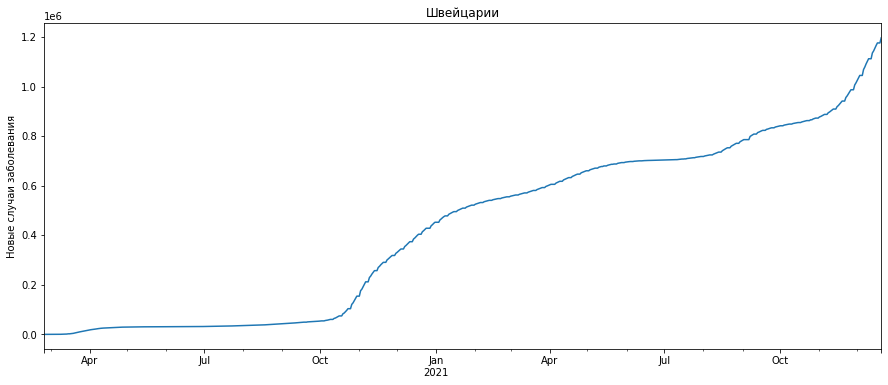

In [21]:
title = 'Швейцарии'
ylabel= 'Новые случаи заболевания'
xlabel=''

ax = df2.total_cases.plot(figsize=(15,6), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [7]:
df2.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,6.460000e+02,646.000000,641.000000,636.000000,636.000000,641.000000,646.000000,646.000000,641.000000,636.000000,636.000000,641.000000,633.000000,612.000000,612.000000,612.000000,612.000000,0.0,0.0,92.000000,92.000000,556.000000,5.560000e+02,556.000000,556.000000,549.000000,549.000000,556.000000,556.000000,3.460000e+02,3.460000e+02,3.460000e+02,319.000000,345.000000,345.000000,346.000000,346.000000,346.000000,319.000000,345.000000,345.000000,345.000000,641.000000,646.0,6.460000e+02,6.460000e+02,6.460000e+02,6.460000e+02,6.460000e+02,0.0,6.460000e+02,6.460000e+02,6.460000e+02,6.460000e+02,0.0,6.460000e+02,6.460000e+02,6.460000e+02,90.000000,90.000000,90.000000,90.000000
mean,4.074950e+05,1586.886997,1556.785599,6637.540881,18.157233,17.926454,46755.234509,182.076557,178.622743,761.579388,2.083310,2.056844,1.141327,176.598039,20.262544,868.877451,99.693415,NaN,NaN,385.739130,44.259022,22308.654676,5.006879e+06,574.480252,2.559640,22340.566485,2.563313,0.073791,34.963849,5.706282e+06,3.114346e+06,2.628841e+06,17322.633229,34735.115942,34324.315942,65.472572,35.733382,30.162543,0.198339,3938.321739,16933.304348,0.194281,50.590998,8715494.0,2.142430e+02,4.310000e+01,1.843600e+01,1.264400e+01,5.741017e+04,NaN,9.973900e+01,5.590000e+00,2.260000e+01,2.890000e+01,NaN,4.530000e+00,8.378000e+01,9.550000e-01,4919.117778,5.428667,8.168222,564.410667
std,3.283870e+05,2680.431208,1748.583582,4298.435337,28.835080,27.610243,37678.534689,307.547837,200.629314,493.194707,3.308493,3.167959,0.400250,146.225378,16.777637,903.212950,103.633017,NaN,NaN,413.275761,47.418519,12628.923942,3.807503e+06,436.866017,1.449001,9822.079535,1.126973,0.062583,45.484764,4.271381e+06,2.172470e+06,2.158348e+06,78555.389766,29452.075161,24271.302008,49.009041,24.926497,24.764724,0.901193,2784.849174,14074.551003,0.161516,11.447008,0.0,7.679808e-13,4.479888e-13,1.777733e-13,6.044293e-14,4.878669e-10,NaN,9.670869e-13,4.266560e-14,2.417717e-13,4.622107e-14,NaN,4.266560e-14,7.253152e-13,2.555492e-15,3930.720530,4.760613,20.156111,451.003756
min,1.000000e+00,0.000000,3.857000,1.000000,-87.000000,-0.143000,0.115000,0.000000,0.443000,0.115000,-9.982000,-0.016000,0.480000,11.000000,1.262000,58.000000,6.655000,NaN,NaN,5.000000,0.574000,1529.000000,2.512000e+03,0.288000,0.175000,3256.000000,0.374000,0.004000,3.700000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,8.330000,8715494.0,2.142430e+02,4.310000e+01,1.843600e+01,1.264400e+01,5.741017e+04,NaN,9.973900e+01,5.590000e+00,2.260000e+01,2.890000e+01,NaN,4.530000e+00,8.378000e+01,9.550000e-01,-1192.800000,-8.

In [25]:
df2.columns

Index(['iso_code', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vac

In [46]:
df3 = df2[['new_cases',
          'total_deaths', 'new_deaths',
          'total_cases_per_million',
          'total_deaths_per_million']] 

Устранение пропусков и дубликатов

In [47]:
df3.isnull().sum()

new_cases                    0
total_deaths                10
new_deaths                  10
total_cases_per_million      0
total_deaths_per_million    10
dtype: int64

In [48]:
df3_n = df3.fillna(0)
df3_n

,new_cases,total_deaths,new_deaths,total_cases_per_million,total_deaths_per_million
date,,,,,
2020-02-25,1.0,0.0,0.0,0.115,0.000
2020-02-26,0.0,0.0,0.0,0.115,0.000
2020-02-27,7.0,0.0,0.0,0.918,0.000
2020-02-28,0.0,0.0,0.0,0.918,0.000
2020-02-29,10.0,0.0,0.0,2.065,0.000
...,...,...,...,...,...
2021-12-16,11077.0,11879.0,25.0,133759.257,1362.975
2021-12-17,9943.0,11910.0,31.0,134900.099,1366.532
2021-12-18,0.0,11909.0,-1.0,134900.099,1366.417


In [49]:
df3_n.duplicated()

date
2020-02-25    False
2020-02-26    False
2020-02-27    False
2020-02-28    False
2020-02-29    False
              ...  
2021-12-16    False
2021-12-17    False
2021-12-18    False
2021-12-19    False
2021-12-20    False
Length: 665, dtype: bool

Устранены пропуски. Дубликатов нет.

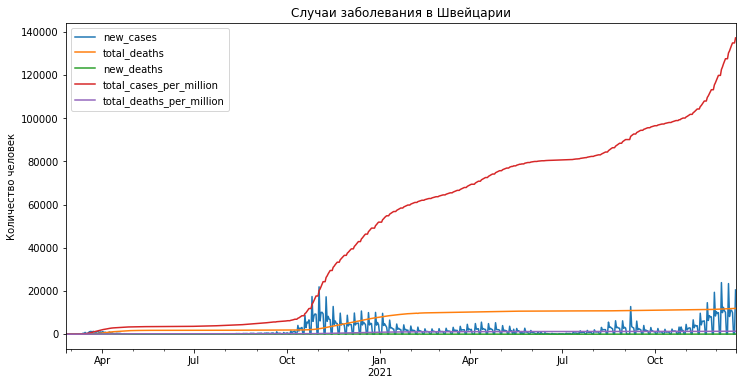

In [50]:
title = 'Случаи заболевания в Швейцарии'
ylabel= 'Количество человек'
xlabel=''

ax1 = df3_n.plot(figsize=(12,6), title=title)
ax1.autoscale(axis='x', tight=True)
ax1.set(xlabel=xlabel, ylabel=ylabel);

In [51]:
df3_n.corr()

,new_cases,total_deaths,new_deaths,total_cases_per_million,total_deaths_per_million
new_cases,1.000000,0.192450,0.407289,0.286062,0.192450
total_deaths,0.192450,1.000000,-0.098081,0.968833,1.000000
new_deaths,0.407289,-0.098081,1.000000,-0.083080,-0.098081
total_cases_per_million,0.286062,0.968833,-0.083080,1.000000,0.968833
total_deaths_per_million,0.192450,1.000000,-0.098081,0.968833,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8cdd73550>,
      dtype=object)

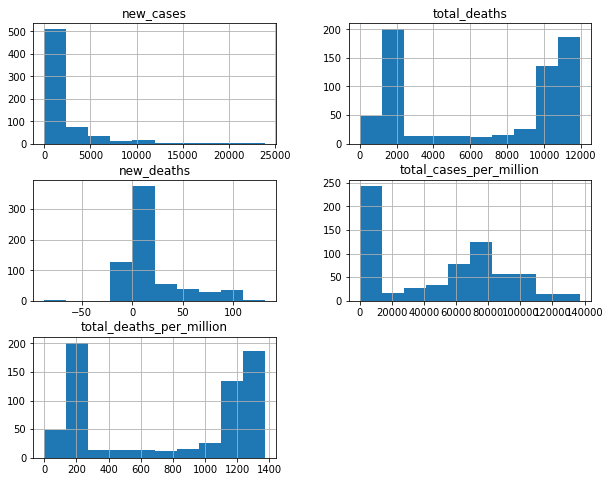

In [55]:
df3_n.hist(figsize=(10,8))

Важна ли сезонность при появлении новых заболевших?

In [33]:
df4 = df3_n[['new_cases']]

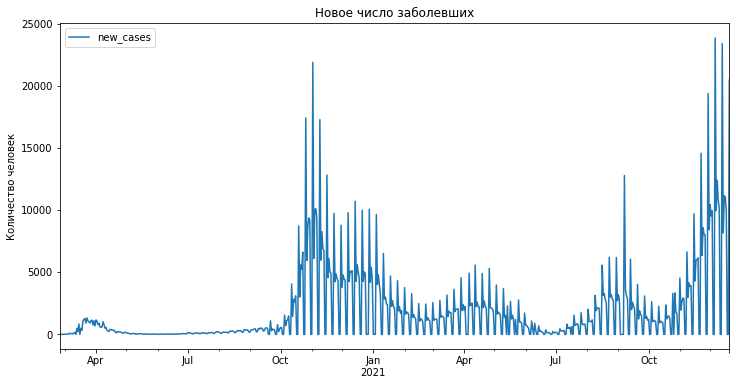

In [34]:
title = 'Новое число заболевших'
ylabel= 'Количество человек'
xlabel=''

ax2 = df4.plot(figsize=(12,6), title=title)
ax2.autoscale(axis='x', tight=True)
ax2.set(xlabel=xlabel, ylabel=ylabel);

Пики новых волн заболеваемости не имеют сезонности, т.к. отсутствует периодичность.

In [36]:
df5 = df3_n[['total_cases_per_million']]

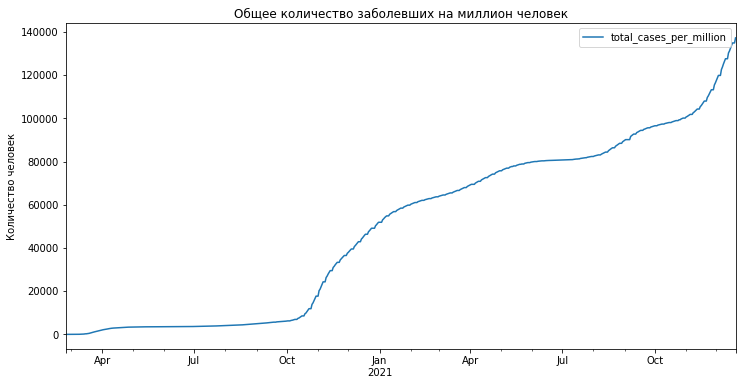

In [37]:
title = 'Общее количество заболевших на миллион человек'
ylabel= 'Количество человек'
xlabel=''

ax3 = df5.plot(figsize=(12,6), title=title)
ax3.autoscale(axis='x', tight=True)
ax3.set(xlabel=xlabel, ylabel=ylabel);

Тренд: Общее количество заболевших всегда будет расти, пока будут новые заболевшие

Гипотеза: Какое будет общее количество случаев заболевания на миллион в период с 5 апреля 2021 года по 5 мая 2021 года

Сбор информации по общему количеству заболевших на миллион человек с начала пандемии по 5 апреля 2021 года

In [38]:
df6 = df5[:'2021-04-05']

In [39]:
df6

,total_cases_per_million
date,
2020-02-25,0.115
2020-02-26,0.115
2020-02-27,0.918
2020-02-28,0.918
2020-02-29,2.065
...,...
2021-04-01,69197.684
2021-04-02,69455.845
2021-04-03,69455.845


Графическое представление данных

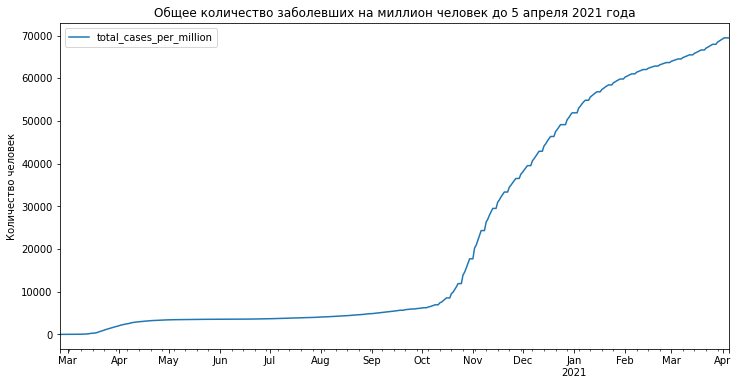

In [56]:
title = 'Общее количество заболевших на миллион человек до 5 апреля 2021 года'
ylabel= 'Количество человек'
xlabel=''

ax3 = df6.plot(figsize=(12,6), title=title)
ax3.autoscale(axis='x', tight=True)
ax3.set(xlabel=xlabel, ylabel=ylabel);

ETS декомпозиция

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [58]:
r = seasonal_decompose(df6['total_cases_per_million'], model='additive')

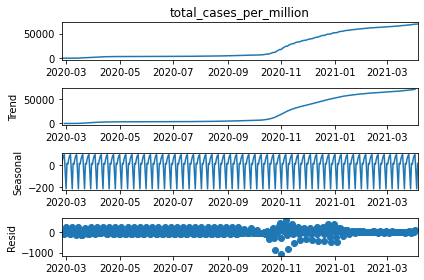

In [59]:
r.plot();

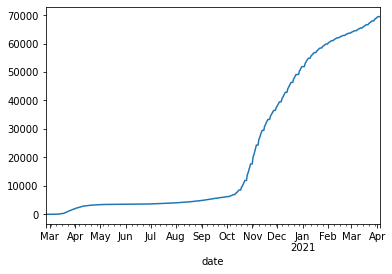

In [60]:
r.observed.plot()

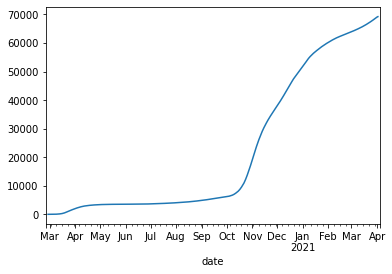

In [61]:
r.trend.plot()

Тренд: Наблюдается общая тенденция к росту заболеваемости

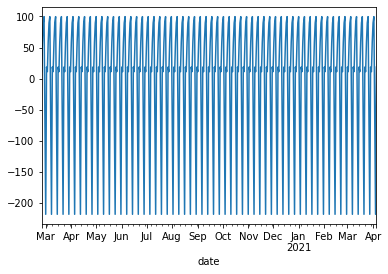

In [62]:
r.seasonal.plot()

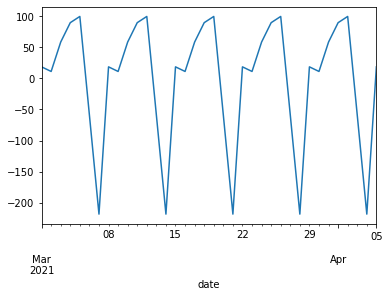

In [64]:
r.seasonal['2021-03-01':'2021-04-05'].plot();

Наблюдается определенная недельная сезонность в масштабе +-150 человек

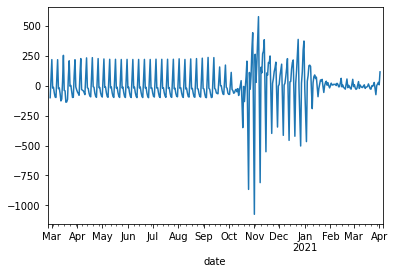

In [65]:
r.resid.plot()

Остатки (+-750 человек) превышают сезонность. Сезонность меньше, чем случайные колебания. Период с сентября 2020 по апрель 2021 является случайным

#Выбор и настройка модели ARIMA

In [92]:
auto_arima(df6['total_cases_per_million'],seasonal=True,d=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  406
Model:               SARIMAX(3, 7, 0)   Log Likelihood               -3654.594
Date:                Tue, 21 Dec 2021   AIC                           7317.188
Time:                        22:08:17   BIC                           7333.143
Sample:                             0   HQIC                          7323.507
                                - 406                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7851      0.022    -80.694      0.000      -1.828      -1.742
ar.L2         -1.4172      0.034    -41.545      0.000      -1.484      -1.350
ar.L3         -0.4822      0.023    -20.527      0.000      -0.528      -0.436
sigma2      5.326e+06   1.57e+05     33.987      0.000    5.02e+06    5.63e+06
===================================================================================
Ljung-Box (L1) (Q):                  87.67   Jarque-Bera (JB):              2894.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             482.32   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Прогнозируем на 1 месяц

In [94]:
train = df6[:'2021-03-05']
test = df6['2021-03-06':]

In [95]:
train

,total_cases_per_million
date,
2020-02-25,0.115
2020-02-26,0.115
2020-02-27,0.918
2020-02-28,0.918
2020-02-29,2.065
...,...
2021-03-01,63965.623
2021-03-02,64095.277
2021-03-03,64235.602


In [96]:
test

,total_cases_per_million
date,
2021-03-06,64516.136
2021-03-07,64516.136
2021-03-08,64830.978
2021-03-09,64989.087
2021-03-10,65160.162
2021-03-11,65321.828
2021-03-12,65474.774
2021-03-13,65474.774
2021-03-14,65474.774


Обучаем модель SARIMA (3, 7, 0)(1, 1, 0, 7)

In [106]:
model = SARIMAX(train['total_cases_per_million'], order = (3, 7, 0), seasonal_order=(1, 1, 0, 7))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:           total_cases_per_million   No. Observations:                  375
Model:             SARIMAX(3, 7, 0)x(1, 1, 0, 7)   Log Likelihood               -2847.950
Date:                           Tue, 21 Dec 2021   AIC                           5705.900
Time:                                   22:11:37   BIC                           5725.344
Sample:                               02-25-2020   HQIC                          5713.630
                                    - 03-05-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9218      0.017   -110.934      0.000      -1.956      -1.888
ar.L2         -1.6750      0.028    -60.078      0.000      -1.730      -1.620
ar.L3         -0.6848      0.018    -38.433      0.000      -0.720      -0.650
ar.S.L7        0.5681      0.017     33.411      0.000       0.535       0.601
sigma2      4.154e+05   1.13e+04     36.921      0.000    3.93e+05    4.37e+05
===================================================================================
Ljung-Box (L1) (Q):                  81.27   Jarque-Bera (JB):              3509.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              29.19   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Прогноз на 1 месяц

In [107]:
#predictions = results.predict(start='2021-03-06', end='2021-04-05', dynamic=False, typ='levels').rename(' SARIMAX(3, 7, 0)x(1, 1, [0], 7) Predictions')

In [128]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(' SARIMAX(3, 7, 0)x(1, 1, [0], 7) Predictions')

In [129]:
#Сравним результаты
for i in range(len(predictions)):
  print(f"predicted={predictions[i]:<11.10}, expected={test['total_cases_per_million'][i]}")

predicted=64562.62392, expected=64516.136
predicted=64367.17812, expected=64516.136
predicted=64811.87247, expected=64830.977999999996
predicted=65119.12475, expected=64989.087
predicted=65187.27645, expected=65160.162000000004
predicted=65242.91558, expected=65321.828
predicted=65399.25406, expected=65474.774000000005
predicted=65518.88144, expected=65474.774000000005
predicted=65553.75444, expected=65474.774000000005
predicted=65806.21193, expected=65838.494
predicted=66114.1942 , expected=66003.488
predicted=65926.76192, expected=66216.671
predicted=66592.07032, expected=66417.463
predicted=66657.58689, expected=66618.025
predicted=66642.53036, expected=66618.025
predicted=66446.71868, expected=66618.025
predicted=67034.69121, expected=67036.017
predicted=67509.72128, expected=67247.594
predicted=67413.67318, expected=67479.594
predicted=67448.89321, expected=67714.349
predicted=68064.73658, expected=67949.906
predicted=68113.36012, expected=67949.906
predicted=67868.65836, expected

Из сравнения результатов видно, что модель довольно хорошо описывает предсказание на месяц.

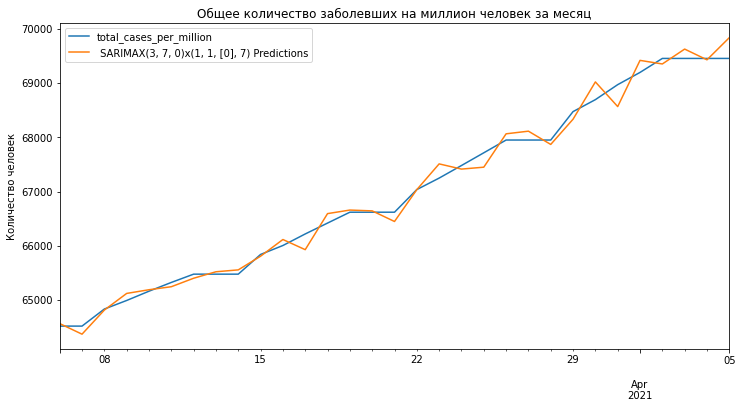

In [140]:
title = 'Общее количество заболевших на миллион человек за месяц'
ylabel= 'Количество человек'
xlabel=''

ax5 = test['total_cases_per_million'].plot(legend=True,figsize=(12,6), title=title)
predictions.plot(legend=True)
ax5.autoscale(axis='x', tight=True)
ax5.set(xlabel=xlabel, ylabel=ylabel);

Проблема: в прогнозе на месяц модель имеет некоторые пикообразные расхождения.

Оценка качество модели с помощью MSE и RMSE

In [131]:
error1 = mean_squared_error(test['total_cases_per_million'], predictions)
error2 = rmse(test['total_cases_per_million'], predictions)
print(f'SARIMAX(3, 7, 0)x(1, 1, [0], 7) MSE Error: {error1:11.10}')
print(f'SARIMAX(3, 7, 0)x(1, 1, [0], 7) RMSE Error: {error2:11.10}')

SARIMAX(3, 7, 0)x(1, 1, [0], 7) MSE Error: 30298.30569
SARIMAX(3, 7, 0)x(1, 1, [0], 7) RMSE Error:  174.064085


Ошибка в расчете на миллион человек не большая - 0.0174 %

Обучение модели на полном датасете и предсказание на неделю вперед

In [185]:
model = SARIMAX(df6['total_cases_per_million'],order=(3, 7, 0),seasonal_order=(1, 1, 0, 7))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            total_cases_per_million   No. Observations:                  406
Model:             SARIMAX(3, 7, 0)x(1, 1, 0, 30)   Log Likelihood               -3467.306
Date:                            Tue, 21 Dec 2021   AIC                           6944.613
Time:                                    23:33:42   BIC                           6964.167
Sample:                                02-25-2020   HQIC                          6952.380
                                     - 04-05-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8199      0.031    -59.514      0.000      -1.880      -1.760
ar.L2         -1.4257      0.045    -31.383      0.000      -1.515      -1.337
ar.L3         -0.4525      0.029    -15.534      0.000      -0.510      -0.395
ar.S.L30      -0.6585      0.028    -23.304      0.000      -0.714      -0.603
sigma2      8.436e+06   1.64e-09   5.15e+15      0.000    8.44e+06    8.44e+06
===================================================================================
Ljung-Box (L1) (Q):                  71.06   Jarque-Bera (JB):               493.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):            1144.98   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+31. Standard errors may be unstable.
"""

In [195]:
fcast = results.predict(len(df6)-1,len(df6)+6,typ='levels').rename(' SARIMAX(3, 7, 0)x(1, 1, [0], 7) Forecast')

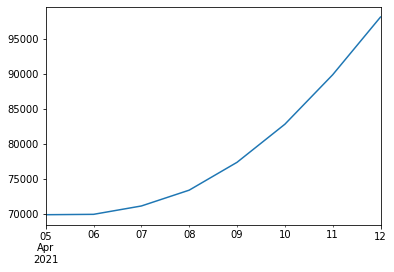

In [196]:
fcast.plot()

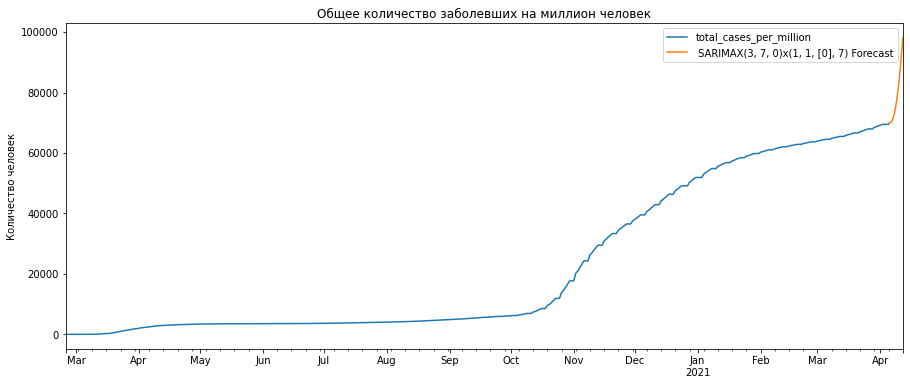

In [198]:
title = 'Общее количество заболевших на миллион человек'
ylabel= 'Количество человек'
xlabel=''

ax = df6['total_cases_per_million'].plot(legend=True,figsize=(15,6), title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Проблема: в прогнозе на месяц прогнозируется падение, когда наша переменная падать не может (она может только расти).

#Модель простейшего экспоненциального сглаживания

In [199]:
# первая модель экспоненциального сглаживания
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

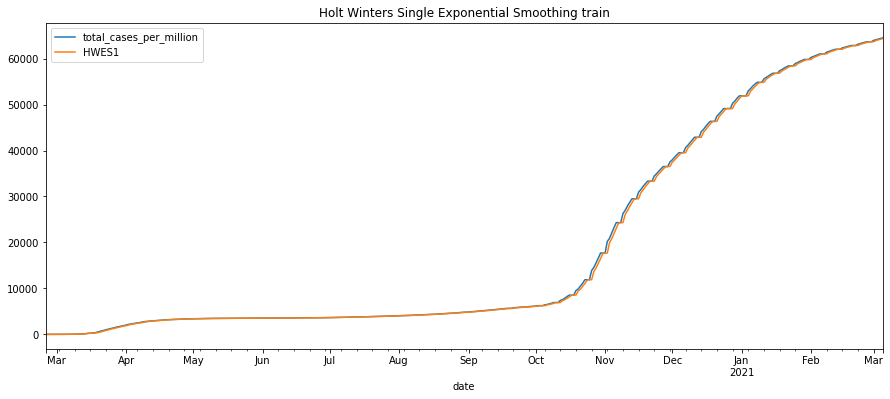

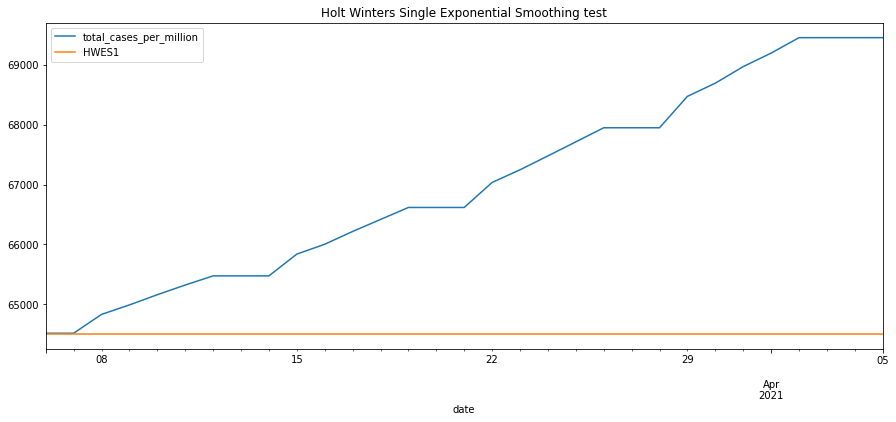

In [200]:
start=len(train)
end=len(train)+len(test)-1
HWE1 = SimpleExpSmoothing (train['total_cases_per_million']).fit(smoothing_level=0.9, optimized=False, use_brute=True)
train['HWES1'] = HWE1.fittedvalues
train[['total_cases_per_million', 'HWES1']].plot(title='Holt Winters Single Exponential Smoothing train', figsize=(15,6));
test['HWES1'] = HWE1.predict(start, end)
test[['total_cases_per_million', 'HWES1']].plot(title='Holt Winters Single Exponential Smoothing test', figsize=(15,6));

Модель HWE1 предсказывает постоянное значение на весь период

In [201]:
HWE1.params_formatted

,name,param,optimized
smoothing_level,alpha,0.900,False
initial_level,l.0,0.115,False


Проблема: Простейшее экспоненциальное сглаживание не видит сезонности. Это не лучшее предсказание, т.к. на весь период предсказано одно количество заболевших, когда наша переменная может только расти

#Модель Holt

In [202]:
# вторая и третья модель экспоненциального сглаживания
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
HWE2 = ExponentialSmoothing (train['total_cases_per_million'], trend='add').fit()
train['HWES2'] = HWE2.fittedvalues
train[['total_cases_per_million', 'HWES2']].plot(title='Holt Winters 2 Exponential Smoothing train', figsize=(15,6));
test['HWES2'] = HWE2.predict(start, end)
test[['total_cases_per_million', 'HWES2']].plot(title='Holt Winters 2 Exponential Smoothing test', figsize=(15,6));

Проблема: Сезонность отсутсвует. Модель обучилась и предсказала, что будет линейный рост, но это не подходит к нашей переменной.

#Модель HoltWinters
##учитывает сезонность, включает в себя модель Holt и экспоненциального скользящего среднего

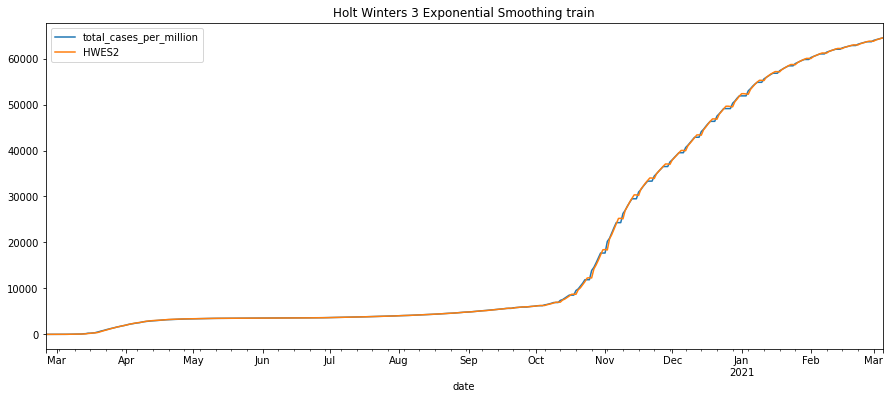

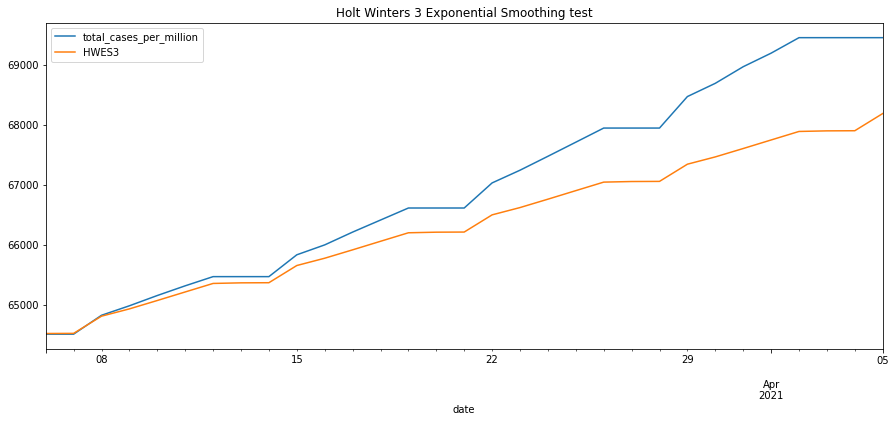

In [204]:
HWE3 = ExponentialSmoothing (train['total_cases_per_million'], trend='add', seasonal='add', seasonal_periods=7).fit()
train['HWES3'] = HWE3.fittedvalues
train[['total_cases_per_million', 'HWES2']].plot(title='Holt Winters 3 Exponential Smoothing train', figsize=(15,6));
test['HWES3'] = HWE3.predict(start, end)
test[['total_cases_per_million', 'HWES3']].plot(title='Holt Winters 3 Exponential Smoothing test', figsize=(15,6));

Модель показывает схожие показатели, которые довольно точно повторяют реальный рост заболеваемости.

In [205]:
test['SARIMAX'] = predictions

In [60]:
test

,total_cases_per_million,HWES1,HWES2,HWES3,SARIMAX
date,,,,,
2021-03-06,64516.136,64500.555531,64645.130316,64527.307018,6.456241e+04
2021-03-07,64516.136,64500.555531,64775.830509,64529.475412,6.460222e+04
2021-03-08,64830.978,64500.555531,64906.530702,64815.906926,6.482236e+04
2021-03-09,64989.087,64500.555531,65037.230895,64937.435665,6.454453e+04
2021-03-10,65160.162,64500.555531,65167.931088,65077.060583,6.358512e+04
2021-03-11,65321.828,64500.555531,65298.631281,65219.464546,6.136402e+04
2021-03-12,65474.774,64500.555531,65429.331474,65361.359962,5.705030e+04
2021-03-13,65474.774,64500.555531,65560.031667,65371.290400,4.937238e+04
2021-03-14,65474.774,64500.555531,65690.731860,65373.458794,3.680241e+04


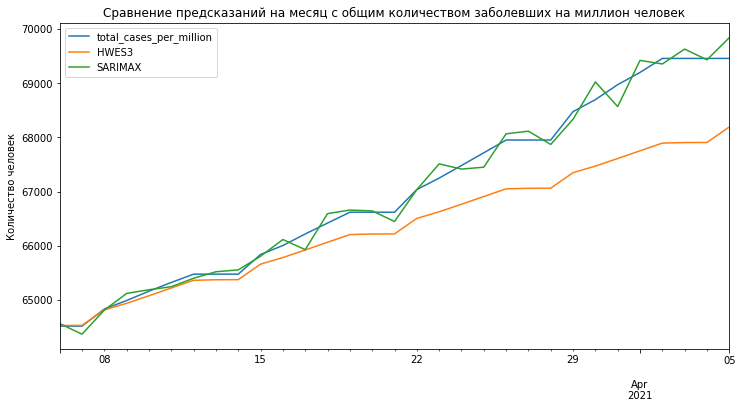

In [206]:
title = 'Сравнение предсказаний на месяц с общим количеством заболевших на миллион человек'
ylabel= 'Количество человек'
xlabel=''

ax = test[['total_cases_per_million', 'HWES3', 'SARIMAX']].plot(legend=True,figsize=(12,6), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Оценка качество модели с помощью MSE и RMSE

In [207]:
error1 = mean_squared_error(test['total_cases_per_million'], test['HWES3'])
error2 = rmse(test['total_cases_per_million'], test['HWES3'])
print(f'HWES3 MSE Error: {error1:11.10}')
print(f'HWES3 RMSE Error: {error2:11.10}')

HWES3 MSE Error: 665874.3156
HWES3 RMSE Error: 816.0112227


Модель HoltWinters дала ошибку rmse меньше, чем модель ARIMA